# Industry Input-Output Tables and Trade Linkages

_8 March 2018_

This notebook is part of a project on industrial effects related to soon-to-be announced tariffs for the U.S. It describes the construction of U.S. Input-Output tables and linkages.

#### Computer-Specific Code Setup

Following lines should be run once. You may need to change this if you're not running this on MW's machine.

## Data Sources

We're making use of the BEA's IO tables in summary form (71 industries last updated in 2016). The main tables are:

- **Use Table (After Redefinitions).** _[Add info]_

#### Useful Resources/Documentation

- [Concepts and Methods of the U.S. Input-Output Accounts](https://www.bea.gov/papers/pdf/IOmanual_092906.pdf) Full BEA documentation of IO Accounting
- [Introducing Domestic Requirements Tables for 1997–2015](https://www.bea.gov/scb/pdf/2017/03%20March/0317_introducing_domestic_requirement_tables.pdf) Primer on how requirements tables work.

## Discussion of Derivation
The IO documentation suggests using

$$
\left[\mathbf{I} -\left(\mathbf{I}-\text{diag}\left(\mathbf{s}\right)\right)^{-1}\mathbf{M}\text{diag}^{-1}\left(\mathbf{q}_{d}\right)\mathbf{U}\text{diag}^{-1}\left(\mathbf{q}_{s}\right)\right]^{-1}
$$
as the total requirements matrix. Here, $\left(\mathbf{I}-\text{diag}\left(\mathbf{s}\right)\right)$ is a term that accounts for the amount of output that goes to scrap in production.

There isn't much intuition given for the formulation. 
The odd thing is that they don't mention anything about that in the direct requirements context. 

I'm going to use that and 

$$
\left(\mathbf{I}-\text{diag}\left(\mathbf{s}\right)\right)^{-1}\mathbf{M}\text{diag}^{-1}\left(\mathbf{q}_{d}\right)\mathbf{U}\text{diag}^{-1}\left(\mathbf{q}_{s}\right)
$$

as the direct requirements matrix while avoiding the scraps when discussing the intuition for what is happening.

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
# May need to reset working directory
# Used for relative paths below
import os 
wkdir = '/home/michael/Dropbox/grantThornton/projects/tariffsTrump/code/py'
os.chdir(wkdir)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

### Make and Use Tables

In [11]:
ut = pd.read_excel(
  '../data/raw/IOUse_After_Redefinitions_PRO_2007_Detail.xlsx',
  sheetname='2007',
  skiprows=5,
  skipfooter=3,
  index_col=0,
  na_values='...'
)

ut.index = [str(idx) for idx in ut.index]
ut.columns = [str(col) for col in ut.columns]
ut.fillna(0, inplace=True)

# Save commodity names for later
comm_names = ut['Commodity Description']
ut.drop('Commodity Description', axis=1, inplace=True)

# Remove Total Commodity Output Columns
ut.drop(['S00101', 'S00201', 'S00202','T001', 'F01000', 'F02S00', 'F02E00', 'F02N00', 'F02R00', 'F03000', 'F04000', 'F05000', 'F06C00', 'F06S00', 'F06E00', 'F06N00', 'F07C00', 'F07S00', 'F07E00', 'F07N00', 'F10C00', 'F10S00', 'F10E00', 'F10N00', 'T004', 'T007'], axis=1, inplace=True)

# Input costs
ic = ut.loc['T005'].T
# Wages
wages = ut.loc['V00100'].T
# Taxes
tax = ut.loc['V00200'].T
# Total Cost
tc = ic + wages + tax
# Total Industry OUTPUT
Yi = ut.loc['T008'].T

# Scrap share
scrap = ut.loc['S00401'].T / Yi

ut.drop(['S00401', 'S00402', 'S00300','T005','V00100', 'V00200', 'V00300', 'T006', 'T008'], axis=0, inplace=True)

In [12]:
mt = pd.read_excel(
  '../data/raw/IOMake_After_Redefinitions_2007_Detail.xlsx',
  sheetname='2007',
  skiprows=5,
  skipfooter=2,
  index_col=0,
  na_values='...'
)

mt.index = [str(idx) for idx in mt.index]
mt.columns = [str(col) for col in mt.columns]
mt.fillna(0, inplace=True)

# Industry names
ind_names = mt['Industry Description']
mt.drop('Industry Description', axis=1, inplace=True)

# Remove Total Commodity Output Columns
mt.drop(['S00101', 'S00201', 'S00202','S00401','T008', 'S00401', 'S00402', 'S00300'], axis=1, inplace=True)

# Total Commodity OUTPUT
Yc = mt.loc['T007'].T
mt.drop(['S00101', 'S00201', 'S00202','T007'], axis=0, inplace=True)

In [13]:
# print(mt.shape, ut.shape, TC.shape, Yc.shape)

## Direct Requirements

In [14]:
II, CC = mt.shape
M = mt.values
U = ut.values
s = scrap.values
TC = tc.values
IC = ic.values


In [15]:
SCRAP_LOSS = np.linalg.inv(np.eye(II) - np.diag(s))
MS = M.dot(np.diag(1/Yc))
DRci = U.dot(np.diag(1/Yi))
DR = SCRAP_LOSS.dot(MS.dot(DRci))

DRdf = pd.DataFrame(DR, index=mt.index, columns=mt.index)

## Total Requirements

In [16]:
TR = np.linalg.inv(np.eye(II) - DR)
TRdf = pd.DataFrame(TR, index=mt.index, columns=mt.index)

### Illustration of Asymptotic Result

In [17]:
idxX = np.random.choice(DR.shape[0], 20)
idxY = np.random.choice(DR.shape[1], 20)

trtp = TR[idxX,idxY]

In [18]:
dd = [np.eye(II)]
dds = [np.eye(II)]
ddf = [np.eye(II)[idxX,idxY]]
for ii in range(25):
    dd.append(dd[-1].dot(DR))
    dds.append(dds[-1]+dd[-1])
    ddf.append(dds[-1][idxX,idxY])
    
ddf = np.vstack(ddf)

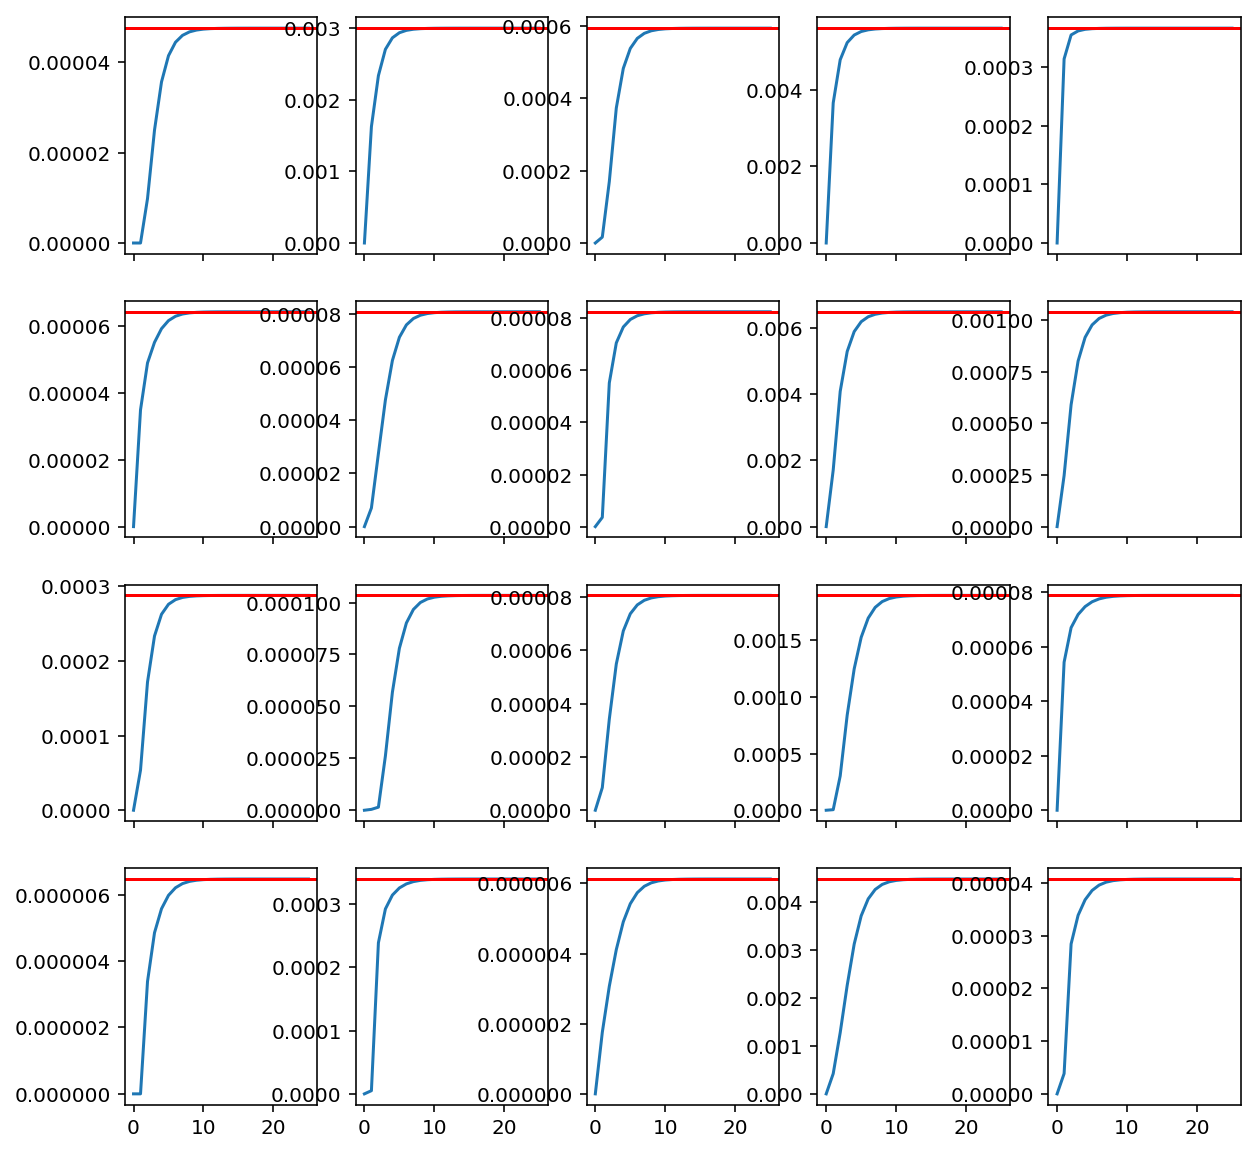

In [19]:
fig,axes = plt.subplots(4,5,sharex=True, sharey=False, figsize=(10,10))
axes = axes.flatten()

for ii,ax in enumerate(axes):
    ax.plot(ddf[:,ii])
    ax.axhline(trtp[ii], c='r')

In [20]:
DRdf.to_pickle('../data/int/DR_io_table.pkl')